In [19]:
from gaitmap.utils.rotations import rotate_dataset, rotation_from_angle
from gaitmap.utils.coordinate_conversion import convert_to_fbf
from gaitmap.stride_segmentation import BarthDtw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from kielmat.utils.kielmat_dataclass import KielMATRecording # Import the KielMATRecording class
from kielmat.modules.gsd import ParaschivIonescuGaitSequenceDetection # Import the Gait Sequence Detection module
from kielmat.datasets import keepcontrol

In [2]:
keepcontrol.fetch_dataset()

In [3]:
# In this example, we use "imu" as tracking_system and "pelvis" as tracked points.
tracking_sys = "imu"
tracked_points = {tracking_sys: ["left_foot", "right_foot", "pelvis"]}

# The 'keepcontrol.load_recording' function is used to load the data from the specified file_path
recording = keepcontrol.load_recording(
    id="pp002",
    task="walkSlow",
    tracking_systems=[tracking_sys], 
    tracked_points=tracked_points
)



In [34]:

"""
Prepares the data for the gaitmap package. This includes:
- rotating the right sensor by -180 deg around the x-axis
- converting the data to the foot-frame
- dropping the lower back sensor

Parameters
----------
data_raw: pd.DataFrame
    The raw data

Returns
-------
data_rotated: pd.DataFrame
    The rotated data
"""
# drop lower back sensor, all columns that contain 'pelvis'
data_gm = recording.data["imu"].drop(columns=[col for col in recording.data["imu"].columns if "pelvis" in col])

# rotate right_sensor by -180 deg around the x-axis
right_rot = rotation_from_angle(
    np.array([0, 0, 1]), np.deg2rad(-180)
)

# make it multiindex, left_foot and right_foot using pandas
# one level being the tracked point and the other being the channels
# Split each column into two parts: foot and channel
split_columns = [(col.split('_', 2)[0] + '_sensor', col.split('_', 2)[2][:3].lower() + '_' + col.split('_', 2)[2][-1]) for col in data_gm.columns]

# Convert to MultiIndex
multiindex_columns = pd.MultiIndex.from_tuples(split_columns, names=["sensor", "axis"])

# Assign the MultiIndex to the DataFrame columns
data_gm.columns = multiindex_columns
data_gm

sensor left_sensor                                                       \
axis         acc_x     acc_y     acc_z      gyr_x      gyr_y      gyr_z   
0        -0.501003 -0.141622  0.856928  -0.088907   0.082052   0.259661   
1        -0.503931 -0.136200  0.855481  -0.702367   0.175827   0.086554   
2        -0.501912 -0.138177  0.849576  -0.346738   0.082052   0.173108   
3        -0.506355 -0.141112  0.857892  -0.266722   0.527480  -0.086554   
4        -0.495650 -0.135753  0.854999   0.266722  -0.257879  -0.259661   
...            ...       ...       ...        ...        ...        ...   
2579     -0.964842 -0.629900  0.626967 -49.139042 -42.573490  97.484344   
2580     -0.887687 -0.331026  0.788108 -22.466864 -42.667263  68.278603   
2581     -0.733377 -0.033683  0.929724 -10.926702 -39.080402  45.465488   
2582     -0.664503  0.193359  0.945754 -13.638373 -30.863436  31.913633   
2583     -0.522412  0.323243  0.950213 -16.172230 -26.584988  27.895063   

sensor                               right_sensor                      \
axis       mag_x     mag_y     mag_z        acc_x     acc_y     acc_z   
0       0.329105  1.127944 -0.824218    -0.500500  0.009290  0.866694   
1       0.331549  1.124271 -0.820310    -0.504431  0.004443  0.865247   
2       0.333994  1.120599 -0.816401    -0.505413  0.003938  0.867221   
3       0.333756  1.124271 -0.816401    -0.507815  0.002928  0.865247   
4       0.333484  1.127944 -0.816401    -0.502902  0.012218  0.872087   
...          ...       ...       ...          ...       ...       ...   
2579    0.706787  0.243425 -0.615225    -0.514694  0.035139  0.857881   
2580    0.706040  0.240237 -0.617194    -0.521027  0.030797  0.860775   
2581    0.701661  0.238297 -0.597887    -0.512183  0.031201  0.863801   
2582    0.697282  0.236322 -0.578610    -0.518079  0.035644  0.867221   
2583    0.699964  0.236565 -0.578375    -0.517096  0.036148  0.864195   

sensor                                                              
axis       gyr_x     gyr_y     gyr_z     mag_x     mag_y     mag_z  
0      -0.436099  0.000000 -0.262789 -0.225090  1.048839 -1.058104  
1       0.170648 -0.346210 -0.262789 -0.223876  1.048839 -1.087883  
2       0.265452  0.000000 -0.091405 -0.222663  1.048839 -1.117662  
3      -0.265452  0.519315  0.000000 -0.220202  1.051268 -1.104261  
4      -0.521423  0.784743  0.525577 -0.217776  1.053697 -1.090826  
...          ...       ...       ...       ...       ...       ...  
2579   -0.872198 -1.396380 -2.799271  0.650382  0.201182 -0.625496  
2580   -1.839201 -0.346210 -2.536483  0.650382  0.199696 -0.624008  
2581   -2.531271 -1.130953 -2.890676  0.650139  0.200204 -0.624256  
2582   -2.445948 -0.519315 -2.890676  0.649897  0.200675 -0.624504  
2583   -2.445948 -0.092323 -2.890676  0.649897  0.204119 -0.618903  

[2584 rows x 18 columns]

In [35]:


# remove all column which contain mag
data_gm = data_gm.loc[:, ~data_gm.columns.get_level_values("axis").str.contains("mag")]

# now use the renamed df
rotations = dict(right_sensor=right_rot)
dataset_sf = rotate_dataset(data_gm, rotations)

# Convert data to foot-frame
data_rotated = convert_to_fbf(dataset_sf, left_like="left_", right_like="right_")



In [17]:
imu_srate = recording.channels["imu"]["sampling_frequency"].unique()[0]

In [36]:
dtw = BarthDtw()
dtw = dtw.segment(data=data_rotated, sampling_rate_hz=imu_srate)


C:\Users\juliu\AppData\Local\Temp\ipykernel_26832\2665884348.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


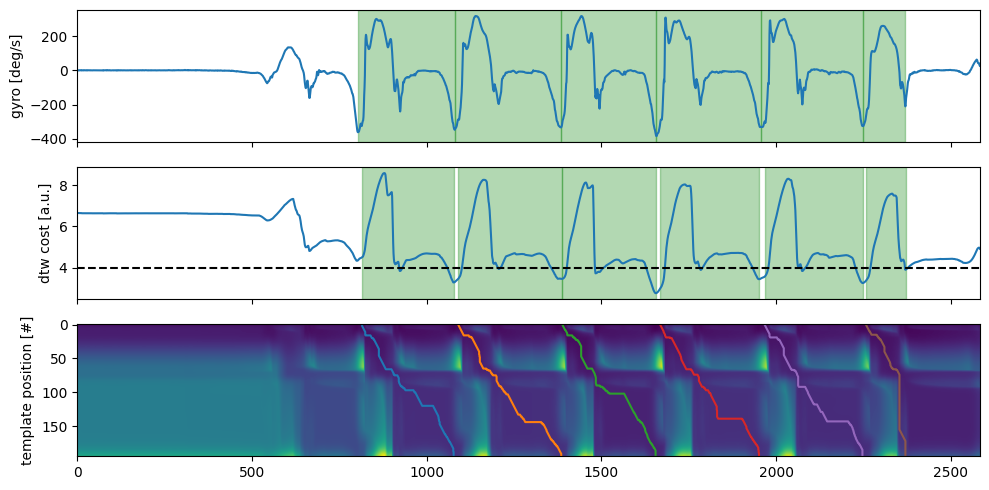

In [38]:
sensor = "left_sensor"
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(10, 5))
dtw.data[sensor]["gyr_ml"].reset_index(drop=True).plot(ax=axs[0])
axs[0].set_ylabel("gyro [deg/s]")
axs[1].plot(dtw.cost_function_[sensor])
axs[1].set_ylabel("dtw cost [a.u.]")
axs[1].axhline(dtw.max_cost, color="k", linestyle="--")
axs[2].imshow(dtw.acc_cost_mat_[sensor], aspect="auto")
axs[2].set_ylabel("template position [#]")
for p in dtw.paths_[sensor]:
    axs[2].plot(p.T[1], p.T[0])
for s in dtw.matches_start_end_original_[sensor]:
    axs[1].axvspan(*s, alpha=0.3, color="g")
for _, s in dtw.stride_list_[sensor][["start", "end"]].iterrows():
    axs[0].axvspan(*s, alpha=0.3, color="g")

axs[0].set_xlabel("time [#]")
fig.tight_layout()
fig.show()

In [51]:
# convert dtw output to pandas df in a bids compatible format and add it to the recording
stride_list = dtw.stride_list_["left_sensor"]

# Create a DataFrame with the stride_list
stride_start_df = pd.DataFrame(
    {
        "onset": stride_list["start"].values,
        "duration": 0,
        "type": "stride_onset",
    }
)

# add stride end to the same df
stride_end_df = pd.DataFrame(
    {
        "onset": stride_list["end"].values,
        "duration": 0,
        "type": "stride_end",
    }
)

# merge the two dataframes
stride_list_df = pd.concat([stride_start_df, stride_end_df], ignore_index=True)

# divide by sampling rate to get the time in seconds
stride_list_df["onset"] /= imu_srate

# sort the DataFrame by the onset
stride_list_df = stride_list_df.sort_values("onset")

# Add the DataFrame to the recording
recording.add_events("imu", stride_list_df)


In [52]:
recording.events["imu"] 

,onset,duration,type
0,803.000,277,NaN
1,1080.000,304,NaN
2,1384.000,273,NaN
3,1657.000,301,NaN
4,1958.000,291,NaN
5,2249.000,121,NaN
6,4.015,277,NaN
7,5.400,304,NaN
8,6.920,273,NaN
9,8.285,301,NaN
